In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime,timedelta
from sklearn.metrics import mean_absolute_error
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:

import json

# --- Core ML Pipeline Class (OOP) ---

class ML_Train:
    """
    Refactored class to encapsulate the ML pipeline steps:
    cleaning, feature engineering, model training, and recursive forecasting.
    """
    
    # Define the target variables for prediction
    TARGETS = [
        'T2M_MAX', 'T2M_MIN', 'T2M', 'RH2M', 
        'WS10M', 'WD10M', 'PRECTOTCORR'
    ]
    
    def __init__(self, data_file='PP_Historical_Weather.csv', city_name="Phnom Penh"):
        """Initializes the system, loading data from the specified CSV."""
        self.city_name = city_name
        self.raw_data = None
        self.df = None  # Engineered DataFrame 
        self.models = {}
        self.training_summary = {}
        self.feature_cols = []
        self.last_row = None # Last row of engineered data for forecast start
        
        try:
            # Load the specified training data file, skipping header rows
            # The new file has the same NASA/POWER header structure
            self.raw_data = pd.read_csv(data_file, skiprows=16) 
            print(f"INFO: Initialized with data from '{data_file}'.")
        except FileNotFoundError:
            raise FileNotFoundError(f"ERROR: Training data file '{data_file}' not found.")

    def clean_data(self):
        """Initial data cleaning and feature generation (e.g., date index, wind components)."""
        df = self.raw_data.copy()
        
        # Create date column from YEAR, MO, DY
        df = df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'})
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        df = df.set_index('date').sort_index()
        
        # Defensive fix: Drop the original year/month/day columns after setting the index
        df = df.drop(columns=['year', 'month', 'day'], errors='ignore')
        
        # Handle missing values (-999)
        df = df.replace(-999, np.nan)
        # Check targets and pressure (PS is needed for feature engineering)
        df = df.dropna(subset=self.TARGETS + ['PS'], how='any') 
        
        # Convert wind speed from m/s to km/h (for reporting, though original WS10M is used for lags)
        df['wind_speed_10m_kmh'] = df['WS10M'] * 3.6
        
        # Additional features: wind direction components
        df['wind_dir_rad'] = np.deg2rad(df['WD10M'])
        df['wind_dir_sin'] = np.sin(df['wind_dir_rad'])
        df['wind_dir_cos'] = np.cos(df['WD10M']) 
        
        print(f"Loaded {len(df)} valid days up to {df.index[-1].date()}")
        
        self.raw_data = df
        return df

    def engineer_features(self, df):
        """Creates time-series (lag) and rolling statistical features."""
        df = df.copy()
        targets = self.TARGETS
        
        # Lags: Past 1-7 days for all targets
        for col in targets:
            for lag in range(1, 8):
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
        
        # Rolling stats
        df['temp_max_roll_mean_3'] = df['T2M_MAX'].rolling(3).mean()
        df['temp_max_roll_mean_7'] = df['T2M_MAX'].rolling(7).mean()
        df['precip_roll_sum_7'] = df['PRECTOTCORR'].rolling(7).sum()
        df['humidity_roll_mean_7'] = df['RH2M'].rolling(7).mean()  
        df['pressure_roll_mean_7'] = df['PS'].rolling(7).mean()    
        
        # Date features (seasonality)
        # These are calculated directly from the DatetimeIndex
        df['month'] = df.index.month
        df['day'] = df.index.day
        df['dayofweek'] = df.index.dayofweek
        df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
        
        # Drop NaN from shifts/rolling (removes the initial 7 rows)
        self.df = df.dropna()
        return self.df
    
    def update_for_realtime_forecast(self, current_df):
        """
        Adjusts the training data to ensure the forecast starts TODAY.
        This is done by appending a proxy row for YESTERDAY based on the last known
        data point, if the last data point is too old.
        
        The recursive series creation method resolves the "Index object has no attribute 'month'" bug.
        """
        if current_df is None or current_df.empty:
            return current_df
        
        # The target date for the last feature set is YESTERDAY
        yesterday = (datetime.now() - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
        
        # Get the date part of the last index entry. This is a Pandas Timestamp.
        last_date_in_df = current_df.index[-1]
        
        # Compare only the date parts to check for data staleness
        if last_date_in_df.date() < yesterday.date():
            # Calculate the required date range to fill
            date_range_to_fill = pd.date_range(start=last_date_in_df + timedelta(days=1), end=yesterday, freq='D')
            
            if len(date_range_to_fill) > 0:
                print(f"WARNING: Historical data ends on {last_date_in_df.date()}.")
                print(f"Injecting {len(date_range_to_fill)} proxy features up to {yesterday.date()} for real-time start.")
                
                # Use the last row of the current data as a template
                last_valid_row = current_df.iloc[-1].copy()
                proxy_rows = []
                
                for dt in date_range_to_fill:
                    # Create a Series for each new day, using the last known values (simple imputation)
                    new_row = last_valid_row.copy()
                    new_row.name = dt # Set the datetime index correctly
                    
                    # Update the date features based on the new index/date
                    new_row['month'] = dt.month
                    new_row['day'] = dt.day
                    new_row['dayofweek'] = dt.weekday()
                    new_row['is_weekend'] = 1 if dt.weekday() >= 5 else 0
                    
                    proxy_rows.append(new_row)
                
                # Append all new proxy rows to the current DataFrame
                # Use the existing columns for alignment, which are present in last_valid_row
                proxy_df = pd.DataFrame(proxy_rows, columns=current_df.columns)
                current_df = pd.concat([current_df, proxy_df])
            
                print(f"Data adjusted. Last data point for feature calculation is now {current_df.index[-1].date()}.")
            
        self.df = current_df
        return self.df


    def train(self):
        """Trains the XGBoost model for each target variable."""
        targets = self.TARGETS
        
        if self.df is None:
            raise RuntimeError("Data must be cleaned and features engineered before training.")
            
        data = self.df
        
        # Define features (lags, rolling stats, date features, pressure, and wind components)
        exclude_cols = targets + ['WD10M', 'wind_dir_rad', 'WS10M', 'wind_speed_10m_kmh']
        self.feature_cols = [col for col in data.columns 
                             if col not in exclude_cols and ('_lag' in col or 'roll' in col or col in ['month', 'day', 'dayofweek', 'is_weekend', 'PS', 'wind_dir_sin', 'wind_dir_cos'])]
        
        self.feature_cols = list(set(self.feature_cols))

        # We need at least one row in the training data, so we check if data has more than 1 row
        if len(data) < 2:
             raise RuntimeError("Not enough historical data or proxy data to train the model and start the forecast.")
             
        # Separate training data from the last row (which holds the features for the first forecast day)
        X = data[self.feature_cols].iloc[:-1]
        
        # The last row of data is used as the starting point for recursive forecasting
        self.last_row = data.iloc[-1]  
        
        # Only train on the historical data (excluding the final proxy row)
        data_train = data.iloc[:-1]
        
        print(f"\nTraining XGBoost models on {len(X)} samples...")

        for target in targets:
            print(f"  → Training {target}...")
            # Use a smaller n_estimators for faster execution, given the larger dataset
            model = xgb.XGBRegressor(
                n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
                colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=1.0,
                random_state=42, n_jobs=-1, tree_method='hist',  
            )
            model.fit(X, data_train[target])
            self.models[target] = model
            
            # Quick accuracy check
            mae = mean_absolute_error(data_train[target], model.predict(X))
            unit = "°C" if 'T2M' in target or 'T2M_MAX' in target or 'T2M_MIN' in target else "mm" if 'PRECTOTCORR' in target else ""
            self.training_summary[target] = f"MAE: {mae:.3f}{unit}"
            print(f"     MAE: {mae:.2f}{unit}")

        print("Training complete!")
        # [Image of a recursive neural network diagram]
        return self.models

    @staticmethod
    def degrees_to_direction(deg):
        """Converts degrees to cardinal direction."""
        deg = deg % 360 
        if deg < 22.5 or deg >= 337.5:   return "N"
        elif deg < 67.5:                 return "NE"
        elif deg < 112.5:                return "E"
        elif deg < 157.5:                return "SE"
        elif deg < 202.5:                return "S"
        elif deg < 247.5:                return "SW"
        elif deg < 292.5:                return "W"
        else:                            return "NW"
        
    def get_training_summary(self):
        """Provides accessible information about the trained models and their performance."""
        return self.training_summary

    def forecast_next_7_days(self, days=7):
        """Recursively forecasts the next N days. This generates a forecast for the 7 days
        immediately following the last date in the training data."""
        if not self.models or self.last_row is None:
            raise RuntimeError("Model must be trained before forecasting.")

        current = self.last_row.copy()
        forecasts = []
        targets = self.TARGETS

        print(f"\nGenerating recursive forecast for the next {days} days...")

        for i in range(1, days + 1):
            
            # 1. Prediction
            # XGBoost requires a 2D array for prediction (1 sample, N features)
            X = current[self.feature_cols].values.reshape(1, -1)
            pred = {}
            for target in targets:
                pred[target] = self.models[target].predict(X)[0]
            
            # Precipitation cannot be negative
            pred['PRECTOTCORR'] = max(0, pred['PRECTOTCORR'])
            # The forecast starts the day after the last historical entry (current.name is the index/date)
            forecast_date = current.name + timedelta(days=1) 
            
            # Weather description
            precip = pred['PRECTOTCORR']
            temp_mean = pred['T2M']
            # Simple rule-based description based on mean temperature and precipitation
            if precip < 0.5:
                desc = "Sunny" if temp_mean >= 33 else "Mostly Sunny" if temp_mean >= 30 else "Partly Cloudy"
            elif precip < 3:
                desc = "Light Rain"
            elif precip < 10:
                desc = "Rainy"
            else:
                desc = "Heavy Rain"

            # Store results in the required format
            forecasts.append({
                "city": self.city_name,
                "date": forecast_date.strftime("%Y-%m-%d"),
                "max_temp": round(pred['T2M_MAX'], 1),
                "min_temp": round(pred['T2M_MIN'], 1),
                "mean_temp": round(pred['T2M'], 1),
                "rain_mm": round(pred['PRECTOTCORR'], 1),
                "wind_speed_kmh": round(pred['WS10M'] * 3.6, 1),
                "wind_dir_deg": round(pred['WD10M'], 0),
                "wind_direction": self.degrees_to_direction(pred['WD10M']),
                "description": desc
            })

            # 2. Feature Update for next iteration
            new_row = current.copy()
            new_row.name = forecast_date
            
            # Update date features for the *next* day's prediction
            new_row['month'] = forecast_date.month
            new_row['day'] = forecast_date.day
            new_row['dayofweek'] = forecast_date.dayofweek
            new_row['is_weekend'] = 1 if forecast_date.weekday() >= 5 else 0

            # Update lag features: Shift existing lags and set lag1 to the new prediction
            for t in targets:
                for lag in range(7, 1, -1):
                    new_row[f'{t}_lag{lag}'] = current[f'{t}_lag{lag-1}']
                new_row[f'{t}_lag1'] = pred[t]
            
            # Update rolling features (approximation using the new prediction and old lags)
            # This is an approximation since we don't have the original time-series data
            new_row['temp_max_roll_mean_3'] = np.mean([
                pred['T2M_MAX'], current['T2M_MAX_lag1'], current['T2M_MAX_lag2']
            ])
            new_row['temp_max_roll_mean_7'] = np.mean([
                pred['T2M_MAX']] + [current[f'T2M_MAX_lag{i}'] for i in range(1, 7)]
            )
            new_row['precip_roll_sum_7'] = sum([
                pred['PRECTOTCORR']] + [current[f'PRECTOTCORR_lag{i}'] for i in range(1, 7)]
            )
            new_row['humidity_roll_mean_7'] = np.mean([
                pred['RH2M']] + [current[f'RH2M_lag{i}'] for i in range(1, 7)]
            )
            new_row['pressure_roll_mean_7'] = current['PS'] # Assume pressure stays constant for simplicity

            # Update wind sin/cos using the predicted WD10M
            rad = np.deg2rad(pred['WD10M'])
            new_row['wind_dir_sin'] = np.sin(rad)
            new_row['wind_dir_cos'] = np.cos(rad)

            # Set the new target values for the next iteration's feature calculation
            for t in targets:
                 new_row[t] = pred[t] 

            current = new_row

        return forecasts

In [3]:

from datetime import datetime, timedelta

# --- Callable Function & Execution ---

def ml_forecast_data(city_name="Phnom Penh"):
    """
    Function to run the ML forecast pipeline.
    It orchestrates the ML_Train class methods and returns the structured forecast data
    for visualization components.
    """
    try:
        # Initialize the system (loads data from 'PP_Historical_Weather.csv' as set in ML_Train)
        system = ML_Train(city_name=city_name)
        
        # 1. Clean Data (Date index, missing value handling)
        df_cleaned = system.clean_data()
        
        # 2. Engineer Features (Lags, Rolling Stats, Date components)
        df_engineered = system.engineer_features(df_cleaned)
        
        # 3. Align the engineered data so the forecast starts today (injects proxy features if needed)
        system.update_for_realtime_forecast(df_engineered) 
        
        # 4. Train Model (Fits XGBoost models for all targets)
        system.train()
        
        # 5. Forecast Next 7 Days (Recursive prediction)
        forecast_results = system.forecast_next_7_days(days=7)
        
        # 6. Get the training metadata (MAE scores)
        training_info = system.get_training_summary()
        
        print("\n--- Training Performance Summary (MAE = Mean Absolute Error) ---")
        for target, metrics in training_info.items():
            print(f"  {target}: {metrics}")
        print("---------------------------------------------------------------")
        
        return forecast_results

    except FileNotFoundError as e:
        print(e)
        return []
    except RuntimeError as e:
        print(f"Runtime Error in ML Pipeline: {e}")
        return []
    except Exception as e:
        # Catch any remaining unexpected errors
        print(f"An unexpected error occurred during ML pipeline execution: {e}")
        return []

if __name__ == '__main__':
    # Execute the function to generate and display the results
    forecast_data = ml_forecast_data("Phnom Penh")

    if forecast_data:
        # Determine the start date for clarity (Day 1 of the forecast)
        forecast_start_date_str = forecast_data[0]['date']
        
        # Print the final result in a clean, tabular format
        print(f"\n7-DAY WEATHER FORECAST RESULT (Callable Output):")
        print(f"Forecast period starts: {forecast_start_date_str}")
        
        # Display the results
        print("-" * 100)
        print(f"{'Date':<12} {'Max Temp':>12} {'Min Temp':>12} {'Mean Temp':>12} {'Rain':>9} {'Wind':>12} {'Dir':>10} {'Weather':<20}")
        print("-" * 100)
        
        for item in forecast_data:
            print(f"{item['date']:<12} "
                  f"{item['max_temp']:>11.1f}° "
                  f"{item['min_temp']:>11.1f}° "
                  f"{item['mean_temp']:>11.1f}° "
                  f"{item['rain_mm']:>8.1f} "
                  f"{item['wind_speed_kmh']:>11.1f} "
                  f"{item['wind_direction']:>10}   "
                  f"{item['description']:<20}")
        
        print("-" * 100)
        print("This output format is ready for visualization parts of your application.")

INFO: Initialized with data from 'PP_Historical_Weather.csv'.
Loaded 5800 valid days up to 2025-11-17
Injecting 13 proxy features up to 2025-11-30 for real-time start.
Data adjusted. Last data point for feature calculation is now 2025-11-30.

Training XGBoost models on 5805 samples...
  → Training T2M_MAX...
     MAE: 0.05°C
  → Training T2M_MIN...
     MAE: 0.12°C
  → Training T2M...
     MAE: 0.08°C
  → Training RH2M...
     MAE: 0.41
  → Training WS10M...
     MAE: 0.15
  → Training WD10M...
     MAE: 2.67
  → Training PRECTOTCORR...
     MAE: 0.25mm
Training complete!

Generating recursive forecast for the next 7 days...

--- Training Performance Summary (MAE = Mean Absolute Error) ---
  T2M_MAX: MAE: 0.050°C
  T2M_MIN: MAE: 0.122°C
  T2M: MAE: 0.077°C
  RH2M: MAE: 0.409
  WS10M: MAE: 0.146
  WD10M: MAE: 2.672
  PRECTOTCORR: MAE: 0.253mm
---------------------------------------------------------------

7-DAY WEATHER FORECAST RESULT (Callable Output):
Forecast period starts: 2025-12-

In [4]:

# --- II. API Fetching and Data Merging Class ---

class API_FETCHING:
    
    #Handles fetching data from OpenWeatherMap and prepares it in a 
    #standardized 8-day format (Current + 7-day forecast).
    
    # NOTE: Replace with your actual key if the mock key stops working
    API_KEY = "dca885a7f61210902aaea785372a6d41" 
    BASE_WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    BASE_ONECALL_URL = "https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude=minutely,hourly,alerts&units=metric&appid={API_KEY}"

    def _get_api_response(self, url, error_msg):
        """Internal helper to handle API requests and errors."""
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error during API call: {error_msg}. Details: {e}")
            return None

    def get_current_weather(self, city):
        """Fetches current weather and structures it for merging."""
        url = self.BASE_WEATHER_URL.format(city=city, API_KEY=self.API_KEY)
        data = self._get_api_response(url, f"Current weather for {city}")
        if not data: return None
        
        # Structure current day data to match the common 8-day format
        return {
            "city": data.get('name', city),
            "date": datetime.fromtimestamp(data['dt']).strftime("%Y-%m-%d (Current)"),
            "max_temp": round(data["main"]["temp_max"], 1),
            "min_temp": round(data["main"]["temp_min"], 1),
            "mean_temp": round(data["main"]["temp"], 1), # Use current temp as the 'mean' for today
            # Use 'rain' or 'snow' 1h/3h data if available, otherwise 0.0
            "rain_mm": data.get("rain", {}).get("1h", data.get("rain", {}).get("3h", 0.0)),
            "description": data["weather"][0]["description"].capitalize()
        }

    def get_forecast_only(self, lat, lon):
        #Fetches 7-day forecast using coordinates
        url2 = self.BASE_ONECALL_URL.format(lat=lat, lon=lon, API_KEY=self.API_KEY)
        data2 = self._get_api_response(url2, "7-day forecast (One Call API 3.0)")
        if not data2 or 'daily' not in data2: return None
        
        forecast_data_list = []
        for day in data2['daily'][:7]: # Limit to next 7 days
            dt = datetime.fromtimestamp(day['dt']) + timedelta(days=1)
            
            # Calculate the average temperature for the day
            mean_temp = round((day['temp']['day'] + day['temp']['eve'] + day['temp']['morn'] + day['temp']['night']) / 4, 1)
            
            forecast_data_list.append({
                "date": dt.strftime("%Y-%m-%d"),
                "max_temp": round(day['temp']['max'], 1),
                "min_temp": round(day['temp']['min'], 1),
                "mean_temp": mean_temp,
                "rain_mm": day.get('rain', 0.0), # Use day.get('rain') which is total precipitation for the day
                "description": day['weather'][0]['description'].capitalize()
            })
        return forecast_data_list

    def get_full_8day_data(self, city_name):
        """Merges current data and 7-day forecast into a single 8-day list."""
        # 1. Get coordinates and current weather data
        current_data_dict = self.get_current_weather(city_name)
        if not current_data_dict: return None
        
        # Extract coordinates from the city check (needs to be refetched if not in current_data_dict,
        # but since get_current_weather uses BASE_WEATHER_URL, we'll quickly refetch coords)
        coord_url = self.BASE_WEATHER_URL.format(city=city_name, API_KEY=self.API_KEY)
        coord_data = self._get_api_response(coord_url, "Coordinates for forecast")
        if not coord_data or 'coord' not in coord_data: return None
        
        lat = coord_data['coord']['lat']
        lon = coord_data['coord']['lon']
        
        # 2. Get 7-day forecast data
        forecast_list = self.get_forecast_only(lat, lon)
        if not forecast_list: return None
        
        # 3. Merge: Current day + 7-day forecast
        full_data = [current_data_dict] + forecast_list
        return full_data

    def cityoption(self):
        """Handles the user I/O menu for fetching, visualization, and comparison."""
        print("\n--- WEATHER TOOL MENU ---")
        province =  ["Phnom Penh", "Banteay Meanchey", "Battambang", "Kampong Cham", "Kampong Chhnang", 
                    "Kampong Speu", "Kampong Thom", "Kampot", "Kandal", "Kep", "Koh Kong", "Kratié", 
                    "Mondulkiri", "Oddar Meanchey", "Pailin", "Preah Vihear", "Preah Sihanouk", 
                    "Prey Veng", "Pursat", "Ratanakiri", "Siem Reap", "Stung Treng", "Svay Rieng", 
                    "Takeo", "Tbong Khmum"]
                    
        for idx, ProvinceName in enumerate(province, start=1):
            print(f"{idx}. {ProvinceName}")
            
        while True:
            try:
                city_name_input = input("Please input the number of the province/city: ")
                city_name_index = int(city_name_input)
                
                if not (1 <= city_name_index <= len(province)):
                    print(f"Invalid input. Please enter a number between 1 and {len(province)}.")
                    continue 

                city = province[city_name_index - 1]
                
                print("\nChoose Action:")
                print("F: API Forecast Visualization (8-Day Combined)")
                print("M: ML Model Forecast Visualization (8-Day Combined, Mock Data)")
                print("C: Compare API vs. ML Model Max Temperatures")
                
                option = input("Enter option (F/M/C): ")
                visualizer = WEATHER_VISUALIZATION() 
                
                match(option.upper()):
                    case "F":
                        full_8day_data = self.get_full_8day_data(city)
                        if full_8day_data:
                            visualizer.plot_8day_combined(full_8day_data, city, source_name="OpenWeatherMap API")
                        break
                        
                    case "M":
                        ml_data = mock_ml_forecast_data(city)
                        if ml_data:
                            visualizer.plot_8day_combined(ml_data, city, source_name="ML Model Prediction (Mock)")
                        break
                        
                    case "C":
                        print("Fetching API data...")
                        api_data = self.get_full_8day_data(city)
                        ml_data = mock_ml_forecast_data(city) # Mock data is always available

                        if api_data and ml_data:
                            visualizer.compare_forecasts(api_data, ml_data, city)
                        else:
                            print("Comparison failed: Could not retrieve API data.")
                        break
                        
                    case _:
                        print("Invalid Option! Please enter F, M, or C.")

            except ValueError:
                print("!!Invalid input. Please enter a valid integer!!.")

In [5]:
# --- III. Reusable Visualization Class ---

class WEATHER_VISUALIZATION:

    #Visualization class that accepts a structured list of data (DataFrame)
    #and plots it. This makes it reusable for both API and ML model data.
    
    
    def plot_8day_combined(self, data_list, city_name, source_name="Data Source"):
        """
        Plots 8 days of data (Current + 7-Day) showing Average Temp (Bar) 
        and Rainfall (Line) with weather annotations.
        """
        if not data_list:
            print(f"Cannot visualize: Data list for {city_name} is empty or None.")
            return

        df = pd.DataFrame(data_list)
        # Remove '(Current)' for cleaner X-axis labels
        df['date'] = df['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # --- 1. Average Temperature (Bar Chart - Primary Axis) ---
        color = 'blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Avg Temp (°C)', color=color)
        bars = ax1.bar(df['date'], df['mean_temp'], color=color, alpha=0.7, label='Average Temp')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_ylim(bottom=df['mean_temp'].min() - 2, top=df['mean_temp'].max() + 5)



        # --- 2. Weather Annotations (Emoji and Description) ---
        for bar, description in zip(bars, df['description']):
            # Use simple emojis based on description
            icon = '☀️' if 'clear' in description.lower() else ('☁️' if 'cloud' in description.lower() else '🌧️')
            
            # Place icon/text above the temperature bar
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, 
                     f"{icon}\n{description}", ha='center', fontsize=9, rotation=0)

        # --- 3. Final Formatting ---
        fig.tight_layout()
        plt.title(f'8-Day Combined Weather Forecast for {city_name.upper()} ({source_name})', fontsize=16)
        plt.xticks(rotation=0, ha='center')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.show()     

    def compare_forecasts(self, api_data, ml_data, city_name):
        
        #Plots a side-by-side comparison of API Max Temp vs ML Model Max Temp.
        #This demonstrates the reusability of the data structure.
    
        if not api_data or not ml_data:
            print("Cannot compare: Missing data for one or both sources.")
            return

        # Convert lists to DataFrames and clean up the date label
        df_api = pd.DataFrame(api_data)
        df_ml = pd.DataFrame(ml_data)
        
        df_api['date'] = df_api['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        df_ml['date'] = df_ml['date'].str.replace(' \(Current\)', '\n(Today)', regex=True)
        
        # Rename columns for clear comparison
        df_api = df_api.rename(columns={'max_temp': 'API_Max'})
        df_ml = df_ml.rename(columns={'max_temp': 'ML_Max'})
        
        # Merge on date for comparison
        df_comp = pd.merge(df_api[['date', 'API_Max']], df_ml[['date', 'ML_Max']], on='date', how='inner')

        plt.figure(figsize=(10, 5))
        
        # Plot API Max Temp
        plt.plot(df_comp['date'], df_comp['API_Max'], marker='o', label='API Max Temp', color='red')
        # Plot ML Max Temp
        plt.plot(df_comp['date'], df_comp['ML_Max'], marker='x', label='ML Max Temp (Mock)', color='green', linestyle='--')
        
        plt.title(f'Max Temperature Comparison for {city_name.upper()} (API vs. ML Model)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Max Temperature (°C)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


--- WEATHER TOOL MENU ---
1. Phnom Penh
2. Banteay Meanchey
3. Battambang
4. Kampong Cham
5. Kampong Chhnang
6. Kampong Speu
7. Kampong Thom
8. Kampot
9. Kandal
10. Kep
11. Koh Kong
12. Kratié
13. Mondulkiri
14. Oddar Meanchey
15. Pailin
16. Preah Vihear
17. Preah Sihanouk
18. Prey Veng
19. Pursat
20. Ratanakiri
21. Siem Reap
22. Stung Treng
23. Svay Rieng
24. Takeo
25. Tbong Khmum
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please enter a valid integer!!.
!!Invalid input. Please en

/var/folders/h_/n_hvysld07s80ry_ldjph_pm0000gn/T/ipykernel_75653/1239565149.py:44: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/opt/anaconda3/envs/food-delivery-prediction/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


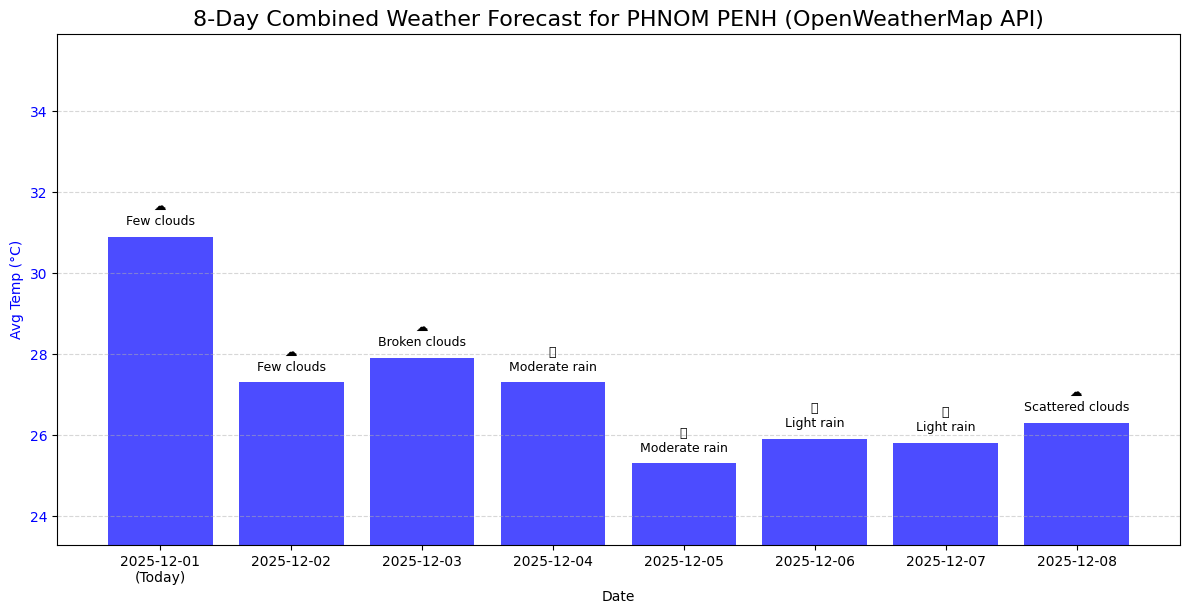

In [6]:
# --- IV. Execution ---

if __name__ == '__main__':
    api_weather = API_FETCHING()
    api_weather.cityoption()